In [134]:
import numpy as np
import numba
print(numba.__version__)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt
import MicroTools.param_scan as param_scan
from MicroTools.param_scan import fast_histogram
from tqdm.notebook import tqdm  # Note the change here
# from tqdm.auto import tqdm

from ipywidgets import IntProgress
from IPython.display import display
from matplotlib.lines import Line2D

0.58.1


In [147]:
g_slices = []
for i in range(9):
    g_slices.append(np.sqrt(0.5*np.pi*i))
labels_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

def plot_all_slices(w_fixed=0.05, global_deltachi2=True, n_sigmas=4, plot_Asimov=False, cmap_color='steelblue', microColor='black', microColor_2='grey', cmin=0.0, cmax=0.8):
    # data4D = param_scan.pickle_read(f"fit_data/MH_decay_4D_30.pkl")
    # cut_in_w = data4D[np.argmin(np.abs(data4D[:,3] == w_fixed)), 3]
    # data3D = data4D[(data4D[:,3] == cut_in_w)]
    # MiniApp_chi2_global = np.min(data3D[:,-3])
    # MicroApp_chi2_global = np.min(data3D[:,-2])
    # MicroApp_Asimov_chi2_global = np.min(data3D[:,-1])

    datamin = param_scan.pickle_read(f"fit_data/MH_decay_goverpi_4.00_Ue4SQRfixed_0.050_2D_60.pkl")
    MiniApp_chi2_global = datamin[np.argmin(datamin[:,-3]), -3]
    datamic = param_scan.pickle_read(f"fit_data/MH_decay_goverpi_0.00_Ue4SQRfixed_0.050_2D_60.pkl")
    MicroApp_chi2_global = datamic[np.argmin(datamic[:,-2]), -2]
    MicroApp_Asimov_chi2_global = datamic[np.argmin(datamic[:,-1]), -1]
    # denote the slices, g^2/pi
    z_slices = []
    # for i in range(9):
    #     z_slices.append(0.5*i)
    z_slices = [0.5*i for i in range(9)]
    
    fig, axs = plt.subplots(3, 3, figsize=(10, 8), sharex=False, sharey=False, constrained_layout=False)
    plt.subplots_adjust(hspace=0.075, wspace=0.05)
    axs = axs.flatten()

    for i in range(9):
        data = param_scan.pickle_read(f"fit_data/MH_decay_goverpi_{z_slices[i]}0_Ue4SQRfixed_0.050_2D_60.pkl")
        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i in [0,3,6]:
            ax.set_ylabel(string_slices[1], fontproperties=pt.font)
        else:
            ax.set_yticklabels([])
            
        if i in [6,7,8]:
            ax.set_xlabel(string_slices[3], fontproperties=pt.font)
        else:
            ax.set_xticklabels([])
        ax.annotate(text=fr"$g_\varphi^2$ $\,= {z_slices[i]} \pi$", 
                    xycoords='axes fraction', 
                    xy=(0.05,0.9), 
                    fontsize=10, 
                    bbox=dict(facecolor='white', edgecolor='None', alpha=0.9, boxstyle='round'))
        # find the minimum of the MiniBooNE Chi2
        x, y, z, w = get_var(data,3), get_var(data,1), get_var(data,0), get_var(data,2)
        MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
        #print(np.min(MiniApp_chi2))
        #print(np.min(MicroApp_chi2))
        i_min = np.argmin(MiniApp_chi2)
        x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
        le = len(np.unique(x))
        kwargs_interp = {'fine_gridx': le,  
                        'fine_gridy': le, 
                        'logx':True, 
                        'logy':True,
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x, y, MiniApp_chi2 - MiniApp_chi2_global, **kwargs_interp)
            ndof = 3
        else:
            X, Y, Z = pt.interp_grid(x, y, MiniApp_chi2-np.min(MiniApp_chi2), **kwargs_interp)
            ndof = 2
        
        colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
        # cs = ax.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=colors, zorder=1, alpha=0.75)
        cs = ax.contourf(X,Y,Z, levels=pt.get_chi2vals_w_CL([0,0.99], ndof), colors=['steelblue'], zorder=1, alpha=0.75)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.99], ndof), colors=['steelblue'], linewidths=0.25, zorder=1, alpha=1)
        ax.scatter(X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x, y, MicroApp_chi2 - MicroApp_chi2_global, **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x, y, MicroApp_chi2 - np.min(MicroApp_chi2), **kwargs_interp)
        # cs = ax.contour(X,Y,Z, levels=[pt.get_chi2vals_w_sigma(2,ndof),pt.get_chi2vals_w_sigma(3,ndof)], colors=[microColor,microColor], zorder=2, linewidths=1.5, linestyles=['-', (1,(3,0.5))])
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.99], ndof), colors=[microColor,microColor], zorder=2, linewidths=1.5, linestyles=['-', (1,(3,0.5))])


        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x, y, MicroApp_Asimov_chi2 - MicroApp_Asimov_chi2_global, **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x, y, MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        if plot_Asimov:
            cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.99], ndof), colors=[microColor_2], linestyles=[(1,(3,0.5))], linewidths=1, zorder=2)
        if i == 8:
            ax.scatter(x_min, y_min, marker='*', facecolor='black', edgecolor='black', lw=0.25, zorder=10)
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on")
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
        if i == 0:
            # ax.plot([], [], color=microColor, lw=1.5, label='$\mu$B 2$\sigma$')
            # ax.plot([], [], color=microColor, lw=1.5, ls=(1,(3,0.5)), label='$\mu$B 3$\sigma$')
            ax.fill_between([], [], facecolor='steelblue', alpha = 0.75, lw=0, label='MB 99\% CL')
            ax.plot([], [], color='black', lw=1.5, label='$\mu$B 99\% CL')
            ax.plot([], [], color='green', lw=1.5, label='IceCube 99\% CL')

            h, l = ax.get_legend_handles_labels()
            # h.append(pt.MulticolorPatch(colors))
            # mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
            # l.append(mb_label)
            ax.legend(h, l, loc=(0,0), fontsize=7, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})
        # Icecube contour
        #ax.annotate('IC 99\% CL', xy=(0.048, 0.5), xycoords='data', rotation=18, color='darkorange', fontsize=9)
        x, y = np.genfromtxt(f'MicroTools/osc_data/IceCube_2024/IceCube_2024_99CL_g{z_slices[i]}p.dat', unpack=True)
        ax.plot(x, y, color='green', lw=1, ls='-', alpha=1,zorder=4)
        # MINOS contour
        # x, y = np.genfromtxt(f'MicroTools/osc_data/MINOS/MINOS_90CL_g{z_slices[i]}p.dat', unpack=True)
        # ax.plot(x, y, color='darkorange', lw=1, ls='-', alpha=1,zorder=4)
    nstring = r'n_{\rm dof}'
    ndof = rf' $\vert$ ${nstring} = {ndof}$'
    axs[1].annotate(text=fr"{string_slices[2]} $\,= {w_fixed:.2f}${ndof}", xycoords='axes fraction', xy=(0.5,1.075), fontsize=10, ha='center', zorder=10)
    fig.savefig(f"{micro.path_plots}/IceCube_allslices_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.pdf", bbox_inches='tight', dpi=300)


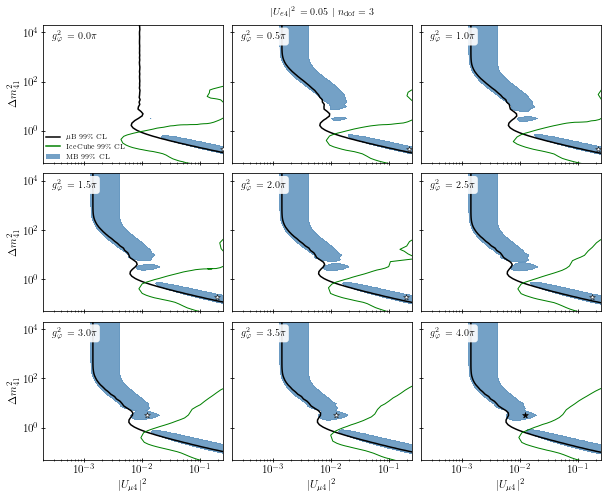

In [148]:
CMAP = 'steelblue'
microColor='black'
microColor_2 = 'steelblue'
kwargs = {'plot_Asimov': False, 'microColor': microColor, 'microColor_2': microColor_2, 'cmap_color': CMAP, 'n_sigmas': 4, 'cmin': 0.0, 'cmax': 0.8}

plot_all_slices(global_deltachi2=True, **kwargs)

In [7]:
z_slices = [0.5*i for i in range(1,9)]
print(z_slices)

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]


In [30]:
print(pt.get_chi2vals_w_CL([0.95, 0.99], 2))

[5.991464547107979, 9.21034037197618]


In [28]:
print(pt.get_chi2vals_w_sigma(2,2))

6.180074306244173


In [56]:
data = param_scan.pickle_read(f"fit_data/MH_decay_4D_30.pkl")
print(np.unique(data[:,3]))

[1.00000000e-04 1.34137649e-04 1.79929088e-04 2.41352649e-04
 3.23744768e-04 4.34263621e-04 5.82511011e-04 7.81366574e-04
 1.04810675e-03 1.40590575e-03 1.88584892e-03 2.52963341e-03
 3.39319078e-03 4.55154633e-03 6.10533723e-03 8.18955581e-03
 1.09852776e-02 1.47353931e-02 1.97657099e-02 2.65132585e-02
 3.55642616e-02 4.77050643e-02 6.39904517e-02 8.58352874e-02
 1.15137436e-01 1.54442650e-01 2.07165740e-01 2.77887252e-01
 3.72751427e-01 5.00000000e-01]
